# Prepare and understand data for modeling

### Duplicates

Consider the following example.

In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder\
       .master("local[*]")\
       .appName("Spark_App")\
       .getOrCreate()

In [2]:
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ], ['id', 'weight', 'height', 'age', 'gender'])

Check for duplicates.

In [3]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 7
Count of distinct rows: 6


If these two numbers differ - you have rows that are exact copies of each other. We can drop these rows by using the `.dropDuplicates(...)` method.

In [4]:
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



Let's confirm.

In [5]:
print('Count of ids: {0}'.format(df.count()))
print('Count of distinct ids: {0}'.format(df.select([c for c in df.columns if c != 'id']).distinct().count()))

Count of ids: 6
Count of distinct ids: 5


We still have one more duplicate. We will use the `.dropDuplicates(...)` but add the `subset` parameter.

In [6]:
df = df.dropDuplicates(subset=[c for c in df.columns if c != 'id'])
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



To calculate the total and distinct number of IDs in one step we can use the `.agg(...)` method.

In [7]:
import pyspark.sql.functions as fn

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



Give each row a unique ID.

In [8]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



### Missing observations

Consider a similar example to the one we presented above.

In [9]:
df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

To find the number of missing observations per row we can use the following snippet.

In [10]:
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

Let's see what values are missing so when we count missing observations in columns we can decide whether to drop the observation altogether or impute some of the observations.

In [11]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



What is the percentage of missing observations we see in each column?

In [12]:
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



We will drop the `'income'` feature as most of its values are missing.

In [13]:
df_miss_no_income = df_miss.select([c for c in df_miss.columns if c != 'income'])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



To drop the observations instead you can use the `.dropna(...)` method.

In [14]:
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



To impute a mean, median or other *calculated* value you need to first calculate the value, create a dict with such values, and then pass it to the `.fillna(...)` method.

In [15]:
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

means['gender'] = 'missing'

df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



### Outliers

Consider another simple example.

In [16]:
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

First, we calculate the lower and upper *cut off* points for each feature.

In [17]:
cols = ['weight', 'height', 'age']
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

The `bounds` dictionary holds the lower and upper bounds for each feature. 

In [18]:
bounds

{'weight': [91.69999999999999, 191.7],
 'height': [4.499999999999999, 6.1000000000000005],
 'age': [-11.0, 93.0]}

Let's now use it to flag our outliers.

In [19]:
outliers = df_outliers.select(*['id'] + [
    (
        (df_outliers[c] < bounds[c][0]) | 
        (df_outliers[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



We have two outliers in the `weight` feature and two in the `age` feature.

In [20]:
df_outliers = df_outliers.join(outliers, on='id')
df_outliers.filter('weight_o').select('id', 'weight').show()
df_outliers.filter('age_o').select('id', 'age').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



## Understand your data

### Descriptive statistics

Load our data and convert it to a Spark `DataFrame`.

In [21]:
# Set File Paths
bankFilePath = "bank.csv"

# Obtain Bank Transaction dataset
bankTransaction = spark.read.csv(bankFilePath, header='true', inferSchema='true', sep=',')
bankTransaction.createOrReplaceTempView("bank_transaction")

In [22]:
import pyspark.sql.types as typ

Now that the dataframe is ready we can calculate the basic descriptive statistics for our dataset. 

In [23]:
bankTransaction.printSchema()

root
 |-- Account_No: string (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- TRANSACTION_DETAILS: string (nullable = true)
 |-- CHQ_NO: double (nullable = true)
 |-- VALUE_DATE: timestamp (nullable = true)
 |-- WITHDRAWAL_AMT: double (nullable = true)
 |-- DEPOSIT_AMT: double (nullable = true)
 |-- BALANCE_AMT: double (nullable = true)



For categorical columns we will count the frequencies of their values using `.groupby(...)` method.

In [24]:
bankTransaction.groupby('TRANSACTION_DETAILS').count().show()

+--------------------+-----+
| TRANSACTION_DETAILS|count|
+--------------------+-----+
|INDO GIBL Indiafo...|    2|
|INDO GIBL Indiafo...|    1|
|INDO GIBL Indiafo...|    1|
|Indfor INCOME IND...|    1|
|BBPS SETMNT FOR D...|    1|
|        632914430004|    1|
|RUPAY POS ACQ SET...|    1|
|RUPAY POS ACQ SET...|    1|
|MASTER POSDOM ACQ...|    6|
|Indiaforensic MAS...|    3|
|Indiaforensic RUP...|    2|
|Indiaforensic VIS...|    1|
|Indiaforensic VIS...|    1|
|Indiaforensic MAS...|    1|
|Indiaforensic RUP...|    1|
|Indiaforensic VIS...|    1|
|Indiaforensic VIS...|    1|
|Indiaforensic RUP...|    1|
|Indiaforensic NFS...|    9|
|Indiaforensic NFS...|   16|
+--------------------+-----+
only showing top 20 rows



For the truly numerical features we can use the `.describe()` method.

In [25]:
numerical = ['WITHDRAWAL_AMT', 'DEPOSIT_AMT', 'BALANCE_AMT']

In [26]:
desc = bankTransaction.describe(numerical)
desc.show()

+-------+--------------------+------------------+--------------------+
|summary|      WITHDRAWAL_AMT|       DEPOSIT_AMT|         BALANCE_AMT|
+-------+--------------------+------------------+--------------------+
|  count|               53549|             62652|              116201|
|   mean|  4489189.9435052015|3806585.8284412315|-1.40485204095369...|
| stddev|1.0848504204712426E7| 8683093.407900866| 5.348201823451492E8|
|    min|                0.01|              0.01|-2.04520114191000...|
|    max|      4.5944754636E8|           5.448E8|           8500000.0|
+-------+--------------------+------------------+--------------------+



Here's how you check skewness (we will do it for the `'balance'` feature only).

In [27]:
bankTransaction.agg({'BALANCE_AMT': 'skewness'}).show()

+---------------------+
|skewness(BALANCE_AMT)|
+---------------------+
|   1.1590612013195618|
+---------------------+



### Correlations

Calculating correlations in PySpark is very easy once your data is in a DataFrame form.

In [28]:
bankTransaction.corr('BALANCE_AMT', 'WITHDRAWAL_AMT')

-0.07289269232679689

In order to create a correlations matrix you can use the script below.

In [29]:
n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(bankTransaction.corr(numerical[i], numerical[j]))
    corr.append(temp)
    
corr

[[1.0, -0.08292704372638937, -0.07289269232679688],
 [None, 1.0, -0.07069081330872727],
 [None, None, 1.0]]

### Visualization

First, let's load the modules and set them up.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

### Histograms

Aggreagate the data in workers and return aggregated list of cut-off points and counts in each bin of the histogram to the driver.

In [31]:
hists = bankTransaction.select('BALANCE_AMT').rdd.flatMap(lambda row: row).histogram(20)

To plot the histogram you can simply call the matplotlib like below.

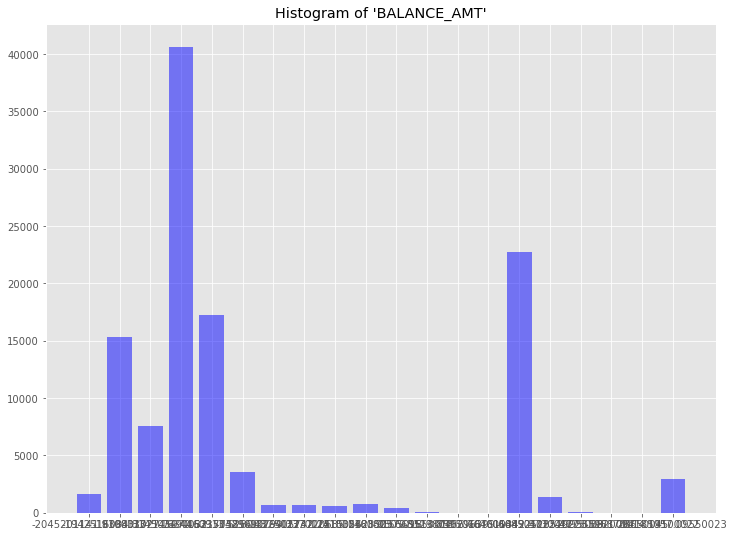

In [32]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

bins = list(map(str, data['bins']))
freq = data['freq']

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(bins, freq, alpha=0.5, color = "blue")
ax.set_title('Histogram of \'BALANCE_AMT\'')

plt.savefig('B05793_05_22.png', dpi=300)

If your data is small enough to fit on the driver (although we would argue it would normally be faster to use the method showed above) you can bring the data and use the `.hist(...)` (from Matplotlib) or `.Histogram(...)` (from Bokeh) methods.

In [33]:
data_driver = {'obs': bankTransaction.select('BALANCE_AMT').rdd.flatMap(lambda row: row).collect()}

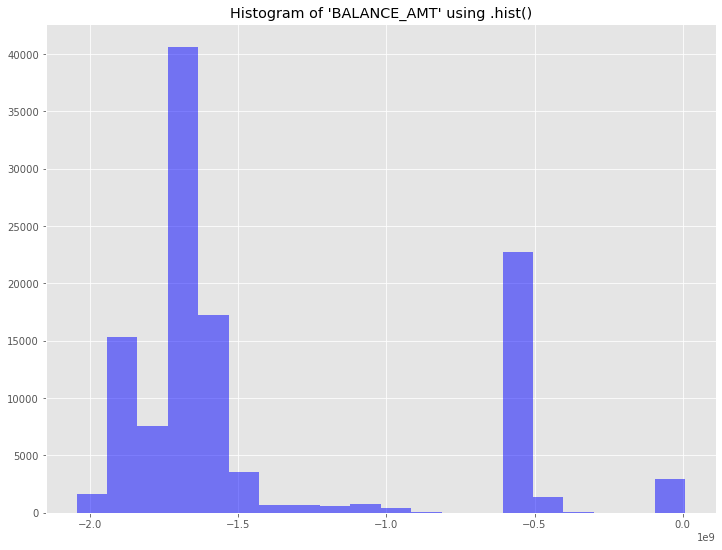

In [34]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)

ax.hist(data_driver['obs'], bins=20, alpha=0.5, color = "blue")
ax.set_title('Histogram of \'BALANCE_AMT\' using .hist()')


plt.savefig('B05793_05_24.png', dpi=300)